# Modelo usando redes recurrentes

## Paso 1: Montar Google Drive y Cargar Datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import os

# Directorio con los archivos procesados
output_dir = "/content/drive/MyDrive/processed_data"
processed_files = [f for f in os.listdir(output_dir) if f.endswith('_II.npy')]

signals = []
labels = []

for filename in processed_files:
    full_signal_path = os.path.join(output_dir, filename)
    data = np.load(full_signal_path, allow_pickle=True).item()
    signals.append(data['signal'])
    labels.append(data['labels'])

signals = np.array(signals, dtype=object)
labels = np.array(labels, dtype=object)

print("Señales cargadas:", signals.shape)
print("Etiquetas cargadas:", labels.shape)


Mounted at /content/drive
Señales cargadas: (740,)
Etiquetas cargadas: (740, 2)


## Paso 2: Normalización Z-score

In [ ]:
def z_score_normalization(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        return signal - mean
    return (signal - mean) / std

normalized_signals = [z_score_normalization(signal) for signal in signals]
normalized_signals = np.array(normalized_signals, dtype=object)

print("Señales normalizadas")


Señales normalizadas


## 3. Implementación del Detector de Picos R

In [ ]:
from scipy.signal import butter, lfilter

def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def derivative(signal):
    b = [1, 2, 0, -2, -1]
    a = 8
    return lfilter(b, a, signal)

def squaring(signal):
    return signal ** 2

def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def detect_r_peaks(signal, fs):
    filtered_signal = bandpass_filter(signal, 5, 15, fs, order=1)
    derivative_signal = derivative(filtered_signal)
    squared_signal = squaring(derivative_signal)
    window_size = int(0.12 * fs)
    averaged_signal = moving_average(squared_signal, window_size)
    peaks = []
    threshold = np.mean(averaged_signal)
    for i in range(1, len(averaged_signal) - 1):
        if averaged_signal[i] > threshold and averaged_signal[i] > averaged_signal[i - 1] and averaged_signal[i] > averaged_signal[i + 1]:
            peaks.append(i)
    return np.array(peaks)

print("Detector de picos R implementado")


Detector de picos R implementado


## Paso 4: Segmentación de las Señales

In [ ]:
def segment_signal(signal, r_peaks, segment_length=360):
    segments = []
    half_length = segment_length // 2
    for r in r_peaks:
        if r - half_length >= 0 and r + half_length < len(signal):
            segments.append(signal[r - half_length:r + half_length])
    return np.array(segments)

fs = 250  # Frecuencia de muestreo de tus señales ECG (ajústalo según tus datos)
segmented_signals = [segment_signal(signal, detect_r_peaks(signal, fs)) for signal in normalized_signals]
segmented_signals = np.array(segmented_signals, dtype=object)

print("Señales segmentadas")


Señales segmentadas


## Paso 5: Preparar Datos para el Modelo con Manejo de Etiquetas Dobles

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Filtrar las señales que no tienen la longitud deseada
filtered_segmented_signals = []
filtered_labels = []

for signal_segments, label_set in zip(segmented_signals, labels):
    valid_segments = [seg for seg in signal_segments if len(seg) == 360]
    if valid_segments:
        filtered_segmented_signals.extend(valid_segments)
        filtered_labels.extend([label_set] * len(valid_segments))

filtered_segmented_signals = np.array(filtered_segmented_signals).reshape(-1, 360, 1)
filtered_labels = np.array(filtered_labels)

# Mapear etiquetas a valores numéricos
alarm_map = {'#False alarm': 0, '#True alarm': 1}
arrhythmia_map = {'#Asystole': 0, '#Bradycardia': 1, '#Tachycardia': 2, '#Ventricular_Flutter_Fib': 3, '#Ventricular_Tachycardia': 4}

# Convertir etiquetas a formato numérico
alarm_labels = np.array([alarm_map[label[1]] for label in filtered_labels])
arrhythmia_labels = np.array([arrhythmia_map[label[0]] for label in filtered_labels])

# Convertir a formato categórico
alarm_labels_categorical = to_categorical(alarm_labels, num_classes=2)
arrhythmia_labels_categorical = to_categorical(arrhythmia_labels, num_classes=5)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_alarm, y_test_alarm = train_test_split(filtered_segmented_signals, alarm_labels_categorical, test_size=0.2, random_state=42)
_, _, y_train_arrhythmia, y_test_arrhythmia = train_test_split(filtered_segmented_signals, arrhythmia_labels_categorical, test_size=0.2, random_state=42)

# Guardar los datos procesados para su uso futuro
np.save('/content/drive/MyDrive/X_train.npy', X_train)
np.save('/content/drive/MyDrive/X_test.npy', X_test)
np.save('/content/drive/MyDrive/y_train_alarm.npy', y_train_alarm)
np.save('/content/drive/MyDrive/y_test_alarm.npy', y_test_alarm)
np.save('/content/drive/MyDrive/y_train_arrhythmia.npy', y_train_arrhythmia)
np.save('/content/drive/MyDrive/y_test_arrhythmia.npy', y_test_arrhythmia)

print("Datos preparados para el modelo:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_alarm shape:", y_train_alarm.shape)
print("y_test_alarm shape:", y_test_alarm.shape)
print("y_train_arrhythmia shape:", y_train_arrhythmia.shape)
print("y_test_arrhythmia shape:", y_test_arrhythmia.shape)


Datos preparados para el modelo:
X_train shape: (681047, 360, 1)
X_test shape: (170262, 360, 1)
y_train_alarm shape: (681047, 2)
y_test_alarm shape: (170262, 2)
y_train_arrhythmia shape: (681047, 5)
y_test_arrhythmia shape: (170262, 5)


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## paso 6: Definir y Entrenar el Modelo RNN

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

# Definir las entradas
input_layer = Input(shape=(360, 1))

# Definir la arquitectura del modelo basada en la tesis
lstm1 = LSTM(64, return_sequences=True)(input_layer)
dropout1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(64, return_sequences=True)(dropout1)
dropout2 = Dropout(0.5)(lstm2)
lstm3 = LSTM(64, return_sequences=False)(dropout2)
dropout3 = Dropout(0.5)(lstm3)
flatten = Flatten()(dropout3)
dense1 = Dense(128, activation='relu')(flatten)
dropout4 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(dropout4)
dropout5 = Dropout(0.5)(dense2)

# Definir la salida de alarm_output
alarm_output = Dense(2, activation='softmax', name='alarm_output')(dropout5)

# Definir la salida de arrhythmia_output
arrhythmia_output = Dense(5, activation='softmax', name='arrhythmia_output')(dropout5)

# Crear el modelo
model = Model(inputs=input_layer, outputs=[alarm_output, arrhythmia_output])

# Compilar el modelo
model.compile(optimizer='adam',
              loss={'alarm_output': 'categorical_crossentropy', 'arrhythmia_output': 'categorical_crossentropy'},
              metrics={'alarm_output': 'accuracy', 'arrhythmia_output': 'accuracy'})

# Definir el callback para guardar el mejor modelo basado en la métrica de validación de la precisión de las arritmias
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/modelo_red_rnn_tesis.h5',  # Nuevo nombre del archivo del modelo
    monitor='val_arrhythmia_output_accuracy',  # Métrica para monitorear
    save_best_only=True,  # Solo guardar el mejor modelo
    mode='max',  # Guardar el modelo con la máxima precisión de validación
    verbose=1  # Mensajes detallados
)

# Entrenar el modelo con el callback de checkpoint
history = model.fit(X_train,
                    {'alarm_output': y_train_alarm, 'arrhythmia_output': y_train_arrhythmia},
                    epochs=20,
                    batch_size=32,  # Puedes ajustar este valor según el tamaño de tu RAM y GPU
                    validation_data=(X_test, {'alarm_output': y_test_alarm, 'arrhythmia_output': y_test_arrhythmia}),
                    callbacks=[checkpoint_callback])

print("Modelo entrenado")


Epoch 1/20
21283/21283 [==============================] - ETA: 0s - loss: 2.0716 - alarm_output_loss: 0.6654 - arrhythmia_output_loss: 1.4062 - alarm_output_accuracy: 0.6150 - arrhythmia_output_accuracy: 0.4489
Epoch 1: val_arrhythmia_output_accuracy improved from -inf to 0.44903, saving model to /content/drive/MyDrive/modelo_red_rnn_tesis.h5
21283/21283 [==============================] - 926s 43ms/step - loss: 2.0716 - alarm_output_loss: 0.6654 - arrhythmia_output_loss: 1.4062 - alarm_output_accuracy: 0.6150 - arrhythmia_output_accuracy: 0.4489 - val_loss: 2.0035 - val_alarm_output_loss: 0.6481 - val_arrhythmia_output_loss: 1.3553 - val_alarm_output_accuracy: 0.6385 - val_arrhythmia_output_accuracy: 0.4490
Epoch 2/20
    3/21283 [..............................] - ETA: 13:30 - loss: 1.9826 - alarm_output_loss: 0.6450 - arrhythmia_output_loss: 1.3376 - alarm_output_accuracy: 0.6146 - arrhythmia_output_accuracy: 0.4167

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21283/21283 [==============================] - ETA: 0s - loss: 1.7171 - alarm_output_loss: 0.5227 - arrhythmia_output_loss: 1.1945 - alarm_output_accuracy: 0.7394 - arrhythmia_output_accuracy: 0.5314
Epoch 2: val_arrhythmia_output_accuracy improved from 0.44903 to 0.61910, saving model to /content/drive/MyDrive/modelo_red_rnn_tesis.h5
21283/21283 [==============================] - 912s 43ms/step - loss: 1.7171 - alarm_output_loss: 0.5227 - arrhythmia_output_loss: 1.1945 - alarm_output_accuracy: 0.7394 - arrhythmia_output_accuracy: 0.5314 - val_loss: 1.4922 - val_alarm_output_loss: 0.4494 - val_arrhythmia_output_loss: 1.0428 - val_alarm_output_accuracy: 0.7853 - val_arrhythmia_output_accuracy: 0.6191
Epoch 3/20
21282/21283 [============================>.] - ETA: 0s - loss: 1.3631 - alarm_output_loss: 0.4003 - arrhythmia_output_loss: 0.9628 - alarm_output_accuracy: 0.8300 - arrhythmia_output_accuracy: 0.6496
Epoch 3: val_arrhythmia_output_accuracy improved from 0.61910 to 0.72555, saving

In [ ]:
# Crear el modelo
model = Model(inputs=input_layer, outputs=[alarm_output, arrhythmia_output])

# Ver el resumen del modelo
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 360, 64)              16896     ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 360, 64)              0         ['lstm[0][0]']                
                                                                                                  
 lstm_1 (LSTM)               (None, 360, 64)              33024     ['dropout[0][0]']             
                                                                                            

## Paso 7: Evaluación General del Modelo

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/modelo_red_rnn_tesis.h5')


In [ ]:
# Evaluar el modelo
loss, alarm_loss, arrhythmia_loss, alarm_accuracy, arrhythmia_accuracy = model.evaluate(X_test,
                                                                                       {'alarm_output': y_test_alarm,
                                                                                        'arrhythmia_output': y_test_arrhythmia})
print(f'Precisión de alarmas en el conjunto de prueba: {alarm_accuracy * 100:.2f}%')
print(f'Precisión de arritmias en el conjunto de prueba: {arrhythmia_accuracy * 100:.2f}%')


5321/5321 [==============================] - 102s 19ms/step - loss: 0.3354 - alarm_output_loss: 0.0849 - arrhythmia_output_loss: 0.2505 - alarm_output_accuracy: 0.9694 - arrhythmia_output_accuracy: 0.9125
Precisión de alarmas en el conjunto de prueba: 96.94%
Precisión de arritmias en el conjunto de prueba: 91.25%


## Paso 8: Evaluación Detallada del Modelo

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predicciones
y_pred_alarm, y_pred_arrhythmia = model.predict(X_test)

# Convertir predicciones de probabilidades a etiquetas
y_pred_alarm_labels = np.argmax(y_pred_alarm, axis=1)
y_pred_arrhythmia_labels = np.argmax(y_pred_arrhythmia, axis=1)

# Convertir etiquetas de prueba a formato categórico
y_test_alarm_labels = np.argmax(y_test_alarm, axis=1)
y_test_arrhythmia_labels = np.argmax(y_test_arrhythmia, axis=1)

# Generar reporte de clasificación para alarmas
print("Reporte de clasificación para alarmas:")
print(classification_report(y_test_alarm_labels, y_pred_alarm_labels, target_names=['False alarm', 'True alarm']))

# Generar reporte de clasificación para arritmias
print("Reporte de clasificación para arritmias:")
print(classification_report(y_test_arrhythmia_labels, y_pred_arrhythmia_labels, target_names=['Asystole', 'Bradycardia', 'Tachycardia', 'Ventricular Flutter/Fib', 'Ventricular Tachycardia']))


5321/5321 [==============================] - 95s 18ms/step
Reporte de clasificación para alarmas:
              precision    recall  f1-score   support

 False alarm       0.98      0.97      0.98    104650
  True alarm       0.96      0.96      0.96     65612

    accuracy                           0.97    170262
   macro avg       0.97      0.97      0.97    170262
weighted avg       0.97      0.97      0.97    170262

Reporte de clasificación para arritmias:
                         precision    recall  f1-score   support

               Asystole       0.91      0.85      0.88     27664
            Bradycardia       0.94      0.86      0.90     14629
            Tachycardia       0.96      0.97      0.96     37389
Ventricular Flutter/Fib       0.85      0.77      0.81     14731
Ventricular Tachycardia       0.90      0.95      0.92     75849

               accuracy                           0.91    170262
              macro avg       0.91      0.88      0.89    170262
           w

## Paso 9: Graficar las Métricas de Entrenamiento

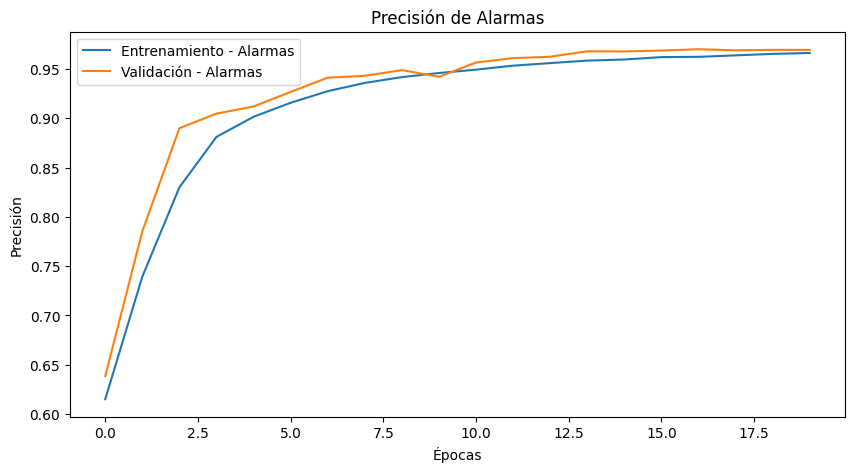

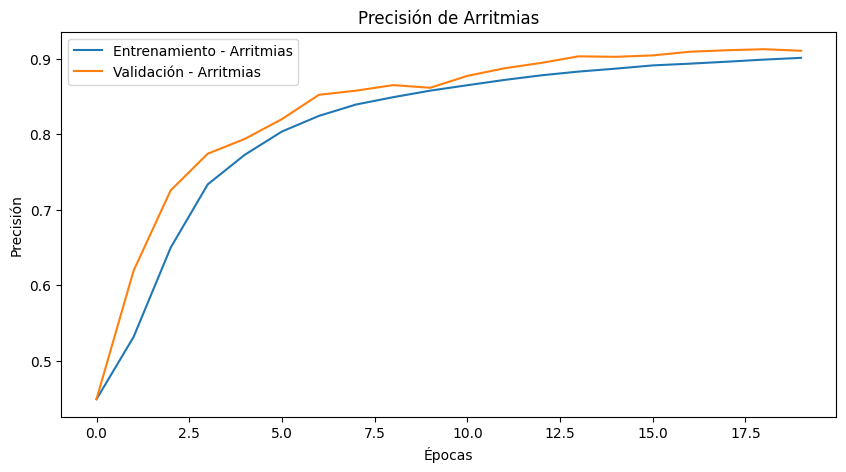

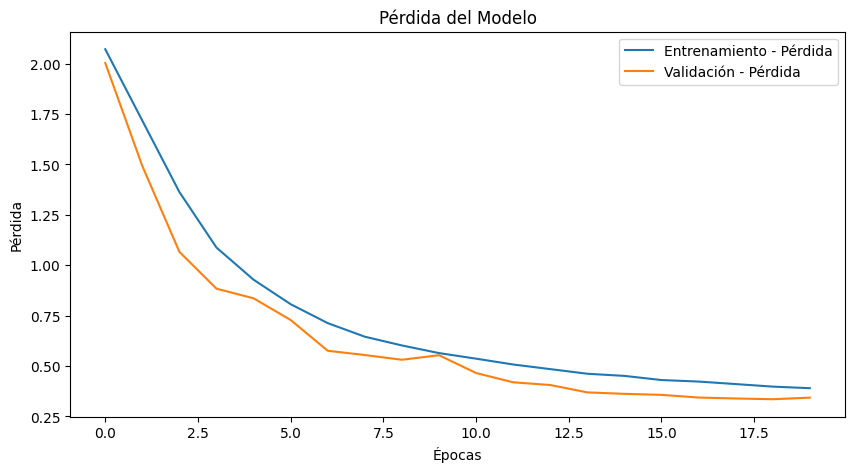

In [ ]:
import matplotlib.pyplot as plt

# Graficar la precisión de las alarmas
plt.figure(figsize=(10, 5))
plt.plot(history.history['alarm_output_accuracy'], label='Entrenamiento - Alarmas')
plt.plot(history.history['val_alarm_output_accuracy'], label='Validación - Alarmas')
plt.title('Precisión de Alarmas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la precisión de las arritmias
plt.figure(figsize=(10, 5))
plt.plot(history.history['arrhythmia_output_accuracy'], label='Entrenamiento - Arritmias')
plt.plot(history.history['val_arrhythmia_output_accuracy'], label='Validación - Arritmias')
plt.title('Precisión de Arritmias')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento - Pérdida')
plt.plot(history.history['val_loss'], label='Validación - Pérdida')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Paso 10: Ajuste de hiperparametros

### Paso 10.1: Definir el Modelo y el Hipermodelo para Ajuste de Hiperparámetros


In [ ]:
!pip install keras-tuner --upgrade
from keras_tuner import HyperModel, BayesianOptimization, Objective
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
import tensorflow as tf

# Definir el modelo con hiperparámetros ajustables
class RNNHyperModel(HyperModel):
    def build(self, hp):
        input_layer = Input(shape=(360, 1))

        lstm1 = LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32), return_sequences=True)(input_layer)
        dropout1 = Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(lstm1)
        lstm2 = LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32), return_sequences=True)(dropout1)
        dropout2 = Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1))(lstm2)
        lstm3 = LSTM(units=hp.Int('lstm_units_3', min_value=32, max_value=128, step=32), return_sequences=False)(dropout2)
        dropout3 = Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1))(lstm3)
        flatten = Flatten()(dropout3)
        dense1 = Dense(units=hp.Int('dense_units_1', min_value=64, max_value=128, step=32), activation='relu')(flatten)
        dropout4 = Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1))(dense1)
        dense2 = Dense(units=hp.Int('dense_units_2', min_value=32, max_value=64, step=32), activation='relu')(dropout4)
        dropout5 = Dropout(rate=hp.Float('dropout_5', min_value=0.1, max_value=0.5, step=0.1))(dense2)

        alarm_output = Dense(2, activation='softmax', name='alarm_output')(dropout5)
        arrhythmia_output = Dense(5, activation='softmax', name='arrhythmia_output')(dropout5)

        model = Model(inputs=input_layer, outputs=[alarm_output, arrhythmia_output])

        model.compile(optimizer='adam',
                      loss={'alarm_output': 'categorical_crossentropy', 'arrhythmia_output': 'categorical_crossentropy'},
                      metrics={'alarm_output': 'accuracy', 'arrhythmia_output': 'accuracy'})

        return model

hypermodel = RNNHyperModel()

tuner = BayesianOptimization(
    hypermodel,
    objective=Objective("val_arrhythmia_output_accuracy", direction="max"),
    max_trials=10,  # Ajusta este valor según tus necesidades
    executions_per_trial=2,
    directory='/content/drive/MyDrive/hyperparameter_tuning',
    project_name='rnn_hyperparam_tuning',
    overwrite=True  # Sobrescribir el proyecto existente
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


### Paso 10.2: Buscar los Hiperparámetros con Early Stopping, ReduceLROnPlateau, y Mantener la Sesión Activa

In [ ]:
# Definir los callbacks para early stopping y reducción de la tasa de aprendizaje
early_stopping = EarlyStopping(monitor='val_arrhythmia_output_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_arrhythmia_output_accuracy', factor=0.2, patience=3, min_lr=0.001)

# Callback para mantener la sesión activa
keep_session_active = LambdaCallback(on_epoch_end=lambda epoch, logs: tf.print(epoch))

# Continuar la búsqueda de hiperparámetros
tuner.search(X_train,
             {'alarm_output': y_train_alarm, 'arrhythmia_output': y_train_arrhythmia},
             epochs=10,
             batch_size=32,  # Usar el mismo tamaño de lote que el modelo original
             validation_data=(X_test, {'alarm_output': y_test_alarm, 'arrhythmia_output': y_test_arrhythmia}),
             callbacks=[early_stopping, reduce_lr, keep_session_active, ModelCheckpoint('/content/drive/MyDrive/best_model.h5', save_best_only=True)])

# Guardar el progreso del tuner nuevamente
tuner.save('/content/drive/MyDrive/tuner_state')



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |lstm_units_1
0.5               |0.5               |dropout_1
32                |32                |lstm_units_2
0.2               |0.2               |dropout_2
96                |96                |lstm_units_3
0.4               |0.4               |dropout_3
128               |128               |dense_units_1
0.3               |0.3               |dropout_4
64                |64                |dense_units_2
0.1               |0.1               |dropout_5

Epoch 1/10
21283/21283 [==============================] - ETA: 0s - loss: 1.8884 - alarm_output_loss: 0.5983 - arrhythmia_output_loss: 1.2901 - alarm_output_accuracy: 0.6787 - arrhythmia_output_accuracy: 0.48430


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21283/21283 [==============================] - 949s 44ms/step - loss: 1.8884 - alarm_output_loss: 0.5983 - arrhythmia_output_loss: 1.2901 - alarm_output_accuracy: 0.6787 - arrhythmia_output_accuracy: 0.4843 - val_loss: 1.7886 - val_alarm_output_loss: 0.5795 - val_arrhythmia_output_loss: 1.2091 - val_alarm_output_accuracy: 0.7208 - val_arrhythmia_output_accuracy: 0.5226 - lr: 0.0010
Epoch 2/10
21283/21283 [==============================] - 939s 44ms/step - loss: 1.4641 - alarm_output_loss: 0.4657 - arrhythmia_output_loss: 0.9984 - alarm_output_accuracy: 0.7832 - arrhythmia_output_accuracy: 0.6146 - val_loss: 1.1940 - val_alarm_output_loss: 0.3892 - val_arrhythmia_output_loss: 0.8048 - val_alarm_output_accuracy: 0.8256 - val_arrhythmia_output_accuracy: 0.6955 - lr: 0.0010
Epoch 3/10
21283/21283 [==============================] - 939s 44ms/step - loss: 1.1124 - alarm_output_loss: 0.3611 - arrhythmia_output_loss: 0.7513 - alarm_output_accuracy: 0.8481 - arrhythmia_output_accuracy: 0.7271 -

### Paso 10.3: Definir y Entrenar el Modelo con los Mejores Hiperparámetros

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback, CSVLogger
import tensorflow as tf

# Definir el modelo con los hiperparámetros obtenidos
input_layer = Input(shape=(360, 1))

lstm1 = LSTM(32, return_sequences=True)(input_layer)
dropout1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(32, return_sequences=True)(dropout1)
dropout2 = Dropout(0.2)(lstm2)
lstm3 = LSTM(96, return_sequences=False)(dropout2)
dropout3 = Dropout(0.4)(lstm3)
flatten = Flatten()(dropout3)
dense1 = Dense(128, activation='relu')(flatten)
dropout4 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dropout4)
dropout5 = Dropout(0.1)(dense2)

alarm_output = Dense(2, activation='softmax', name='alarm_output')(dropout5)
arrhythmia_output = Dense(5, activation='softmax', name='arrhythmia_output')(dropout5)

model = Model(inputs=input_layer, outputs=[alarm_output, arrhythmia_output])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss={'alarm_output': 'categorical_crossentropy', 'arrhythmia_output': 'categorical_crossentropy'},
              metrics={'alarm_output': 'accuracy', 'arrhythmia_output': 'accuracy'})

# Definir los callbacks para early stopping, guardar el progreso y CSV logger
early_stopping = EarlyStopping(monitor='val_arrhythmia_output_accuracy', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/best_model_final_unique_name.h5', save_best_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/training_log.csv', append=True)

def save_progress(epoch, logs):
    model.save(f'/content/drive/MyDrive/intermediate_model_epoch_{epoch+1}_unique_name.h5')
    tf.print(f"Epoch {epoch+1} progress saved")

keep_session_active = LambdaCallback(on_epoch_end=save_progress)

# Entrenar el modelo con los callbacks definidos
history = model.fit(X_train,
                    {'alarm_output': y_train_alarm, 'arrhythmia_output': y_train_arrhythmia},
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, {'alarm_output': y_test_alarm, 'arrhythmia_output': y_test_arrhythmia}),
                    callbacks=[early_stopping, keep_session_active, checkpoint_callback, csv_logger])


Epoch 1/20
21283/21283 [==============================] - 955s 45ms/step - loss: 1.9132 - alarm_output_loss: 0.6066 - arrhythmia_output_loss: 1.3066 - alarm_output_accuracy: 0.6711 - arrhythmia_output_accuracy: 0.4788 - val_loss: 1.6524 - val_alarm_output_loss: 0.5045 - val_arrhythmia_output_loss: 1.1479 - val_alarm_output_accuracy: 0.7580 - val_arrhythmia_output_accuracy: 0.5289
Epoch 2/20
21283/21283 [==============================] - 950s 45ms/step - loss: 1.4803 - alarm_output_loss: 0.4522 - arrhythmia_output_loss: 1.0281 - alarm_output_accuracy: 0.7962 - arrhythmia_output_accuracy: 0.6025 - val_loss: 1.2049 - val_alarm_output_loss: 0.3803 - val_arrhythmia_output_loss: 0.8246 - val_alarm_output_accuracy: 0.8428 - val_arrhythmia_output_accuracy: 0.6971
Epoch 3/20
21283/21283 [==============================] - 947s 44ms/step - loss: 1.1669 - alarm_output_loss: 0.3656 - arrhythmia_output_loss: 0.8013 - alarm_output_accuracy: 0.8483 - arrhythmia_output_accuracy: 0.7135 - val_loss: 0.94

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 360, 1)]             0         []                            
                                                                                                  
 lstm_6 (LSTM)               (None, 360, 32)              4352      ['input_3[0][0]']             
                                                                                                  
 dropout_10 (Dropout)        (None, 360, 32)              0         ['lstm_6[0][0]']              
                                                                                                  
 lstm_7 (LSTM)               (None, 360, 32)              8320      ['dropout_10[0][0]']          
                                                                                            

### Paso 10.4: Evaluar el Modelo y Generar Reportes de Clasificación

In [ ]:
# Evaluar el modelo
loss, alarm_loss, arrhythmia_loss, alarm_accuracy, arrhythmia_accuracy = model.evaluate(X_test,
                                                                                       {'alarm_output': y_test_alarm,
                                                                                        'arrhythmia_output': y_test_arrhythmia})
print(f'Precisión de alarmas en el conjunto de prueba: {alarm_accuracy * 100:.2f}%')
print(f'Precisión de arritmias en el conjunto de prueba: {arrhythmia_accuracy * 100:.2f}%')

# Predicciones
y_pred_alarm, y_pred_arrhythmia = model.predict(X_test)

# Convertir predicciones de probabilidades a etiquetas
import numpy as np
from sklearn.metrics import classification_report

y_pred_alarm_labels = np.argmax(y_pred_alarm, axis=1)
y_pred_arrhythmia_labels = np.argmax(y_pred_arrhythmia, axis=1)

# Convertir etiquetas de prueba a formato categórico
y_test_alarm_labels = np.argmax(y_test_alarm, axis=1)
y_test_arrhythmia_labels = np.argmax(y_test_arrhythmia, axis=1)

# Generar reporte de clasificación para alarmas
print("Reporte de clasificación para alarmas:")
print(classification_report(y_test_alarm_labels, y_pred_alarm_labels, target_names=['False alarm', 'True alarm']))

# Generar reporte de clasificación para arritmias
print("Reporte de clasificación para arritmias:")
print(classification_report(y_test_arrhythmia_labels, y_pred_arrhythmia_labels, target_names=['Asystole', 'Bradycardia', 'Tachycardia', 'Ventricular Flutter/Fib', 'Ventricular Tachycardia']))


5321/5321 [==============================] - 102s 19ms/step - loss: 0.2952 - alarm_output_loss: 0.0746 - arrhythmia_output_loss: 0.2206 - alarm_output_accuracy: 0.9736 - arrhythmia_output_accuracy: 0.9210
Precisión de alarmas en el conjunto de prueba: 97.36%
Precisión de arritmias en el conjunto de prueba: 92.10%
5321/5321 [==============================] - 97s 18ms/step
Reporte de clasificación para alarmas:
              precision    recall  f1-score   support

 False alarm       0.97      0.98      0.98    104650
  True alarm       0.98      0.96      0.97     65612

    accuracy                           0.97    170262
   macro avg       0.97      0.97      0.97    170262
weighted avg       0.97      0.97      0.97    170262

Reporte de clasificación para arritmias:
                         precision    recall  f1-score   support

               Asystole       0.90      0.88      0.89     27664
            Bradycardia       0.95      0.85      0.90     14629
            Tachycardia

### Paso 10.5: Graficar las Métricas de Entrenamiento

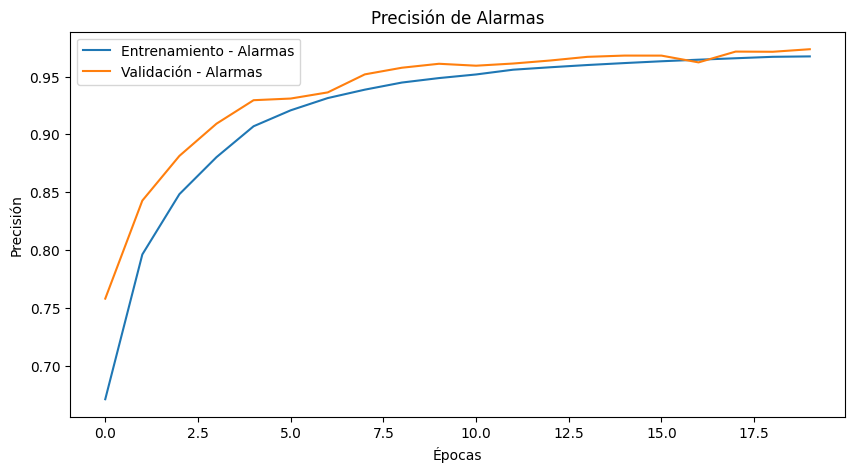

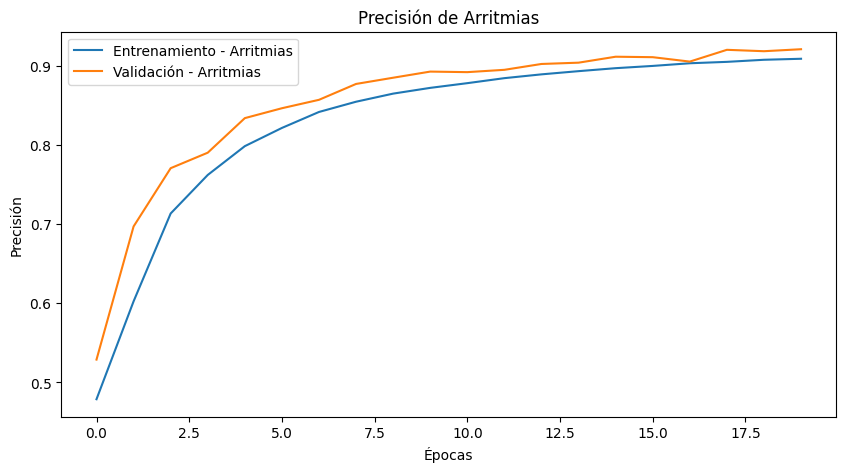

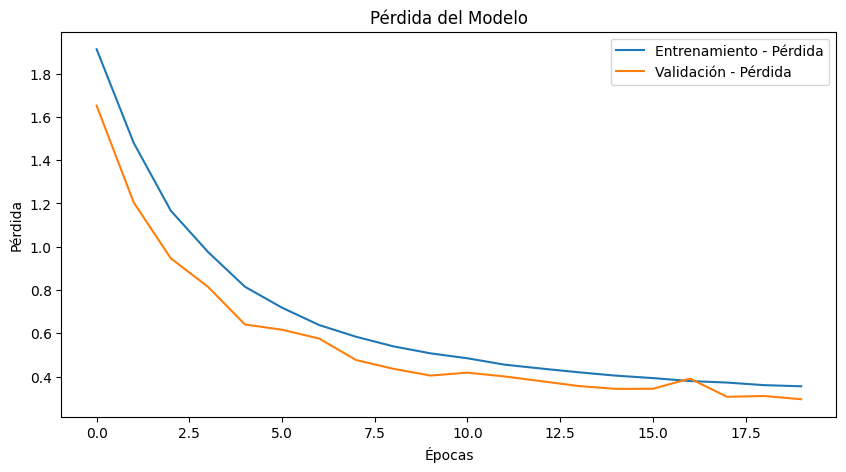

In [ ]:
import matplotlib.pyplot as plt

# Graficar la precisión de las alarmas
plt.figure(figsize=(10, 5))
plt.plot(history.history['alarm_output_accuracy'], label='Entrenamiento - Alarmas')
plt.plot(history.history['val_alarm_output_accuracy'], label='Validación - Alarmas')
plt.title('Precisión de Alarmas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la precisión de las arritmias
plt.figure(figsize=(10, 5))
plt.plot(history.history['arrhythmia_output_accuracy'], label='Entrenamiento - Arritmias')
plt.plot(history.history['val_arrhythmia_output_accuracy'], label='Validación - Arritmias')
plt.title('Precisión de Arritmias')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento - Pérdida')
plt.plot(history.history['val_loss'], label='Validación - Pérdida')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
